# Zendesk Support Challenge 

**Problem**: The VP of Customer Advocacy has asked our team to evaluate how well we have been
supporting our customers over the last few quarters, and to provide meaningful business
insights.

**Why is Customer Service matter to the business ?**: 
A successful customer service team can help attract new business, boost retention, and increase sales among our existing customer base. But it is also a high stakes game:
- 73 % of consumers will leave for a competitor after multiple poor interactions 
- more than half will bolt after a single bad experience, according to the Zendesk Customer Experience Trends Report 2023. 
- Make it two negative experiences, and 76 percent of customers are out the door.

## Evaluate how well we have been supporting our customers

**What makes an excellent customer service ?**

Good customer service means consistently meeting customers’ expectations. Great customer service is **quick, easy, personalized, and empathetic**. Companies that deliver excellent customer service take the time needed to understand the needs of their unique customer base.


**Important Segments**: Channel, Tier, Plan, Group


### CSAT 

### First Reply Time (FRT)

makes sense to segment by channel

### Ticket Resolution Time 



### Ticket Response Rate 



## Lines of Research 

1. Are we optimizing ticket assigning by priority ? by predicting ticket resolution time 
2. Are we maximizing performance on each channel ?
3. Are we performing well on all customer segments ?
4. How can we increase the ticket response rate ? 



In [10]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import randint

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

import re
import string

from scipy import stats
from scipy.stats import norm, skew #for some statistics

credentials = service_account.Credentials.from_service_account_file(
'/Users/joaolousada/Downloads/solar-vertex-380321-55f7948b7f6a.json') 

project_id = 'solar-vertex-380321'
client = bigquery.Client(credentials= credentials,project=project_id)

In [237]:
import pandas_gbq

sql = """
SELECT *
FROM solar-vertex-380321.zendesk.zentest
"""
df_raw = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|██████████|


In [238]:
df = df_raw.copy()
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
0,938,chat,Support (T1),2536525,2017-04-20,Enterprise Legacy,None,Tier 1,317,<NA>,11,15,0,<NA>,2014-11-10,Dublin,Employee,892
1,938,chat,Support (T1),2522091,2017-04-14,Enterprise Legacy,None,Tier 1,10260,<NA>,14,22,0,<NA>,2014-11-10,Dublin,Employee,886
2,1247,web,Support (T1),2836287,2017-08-03,Enterprise Legacy,None,Tier 1,<NA>,<NA>,4,<NA>,0,<NA>,2015-04-20,Dublin,Employee,836
3,919,help_center,Support (T1),3003180,2017-10-02,Enterprise Legacy,None,Tier 1,<NA>,<NA>,3,1,0,<NA>,2014-10-27,Madison,Employee,1071
4,919,help_center,Support (T1),3003011,2017-10-02,Enterprise Legacy,None,Tier 1,<NA>,<NA>,3,1,0,<NA>,2014-10-27,Madison,Employee,1071


In [239]:
df.describe()

,EmployeeID,TicketID,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerTenure
count,240665.000000,2.406650e+05,157169.000000,239741.000000,195237.000000,192623.000000,240665.000000,45554.000000,240665.000000
mean,1853.958444,2.612557e+06,813.261088,5949.678053,3.100309,3.834443,0.159300,0.939500,514.366223
std,651.379958,2.820156e+05,6446.203622,19227.491206,3.499996,4.566357,0.365957,0.238413,353.778344
min,1.000000,2.116910e+06,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-223.000000
25%,1488.000000,2.340143e+06,14.000000,13.000000,1.000000,2.000000,0.000000,1.000000,262.000000
50%,1975.000000,2.629618e+06,53.000000,116.000000,2.000000,2.000000,0.000000,1.000000,469.000000
75%,2362.000000,2.849437e+06,236.000000,8112.000000,4.000000,4.000000,0.000000,1.000000,675.000000
max,3411.000000,3.224171e+06,498116.000000,548814.000000,370.000000,245.000000,1.000000,1.000000,2334.000000


Duplicates


In [240]:
print(f'Number of duplicates - {df[df.duplicated()].nunique().sum()}')

Number of duplicates - 0


Missing Values

In [241]:
missing = df.isnull().sum()
missing = 100*missing[missing > 0]/df.shape[0]
missing.sort_values(inplace=True)
missing
#plt.savefig('images/MV.eps', format='eps', transparent = True)

DayTicketSolved          0.383936
FullResolutionTime       0.383936
AssigneeTier            13.568654
NumAgentComments        18.876031
NumPublicComments       19.962188
ZendeskPlan             26.150874
FirstReplyTime          34.693869
CustomerSatisfaction    81.071614
dtype: float64

In [242]:
for col in ('AssigneeTier', 'ZendeskPlan'):
    df[col] = df[col].fillna('None')

for col in ('NumPublicComments', 'NumAgentComments'):
    df[col] = df[col].fillna(0)

df['FirstReplyTime'] = df['FirstReplyTime'].fillna(0)

# Drop open tickets
df = df.dropna(subset=['FullResolutionTime', 'DayTicketSolved'])

df["CustomerSatisfaction"] = df["CustomerSatisfaction"].replace({0: -1}).fillna(0)

In [280]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,-1,2014-06-01,Manila,Employee,962
925,1463,chat,Zopim T1,2132608,2017-01-06,None,Friday,None,0,4,0,0,0,0,2015-08-03,Manila,Employee,522
926,1463,chat,Zopim T1,2132014,2017-01-06,None,Friday,None,0,35,0,0,0,0,2015-08-03,Manila,Employee,522
927,1463,chat,Zopim T1,2878472,2017-08-18,None,Friday,None,0,0,0,0,0,0,2015-08-03,Manila,Employee,746
928,1463,chat,Zopim T1,2483674,2017-03-31,None,Friday,None,0,2,0,0,0,0,2015-08-03,Manila,Employee,606


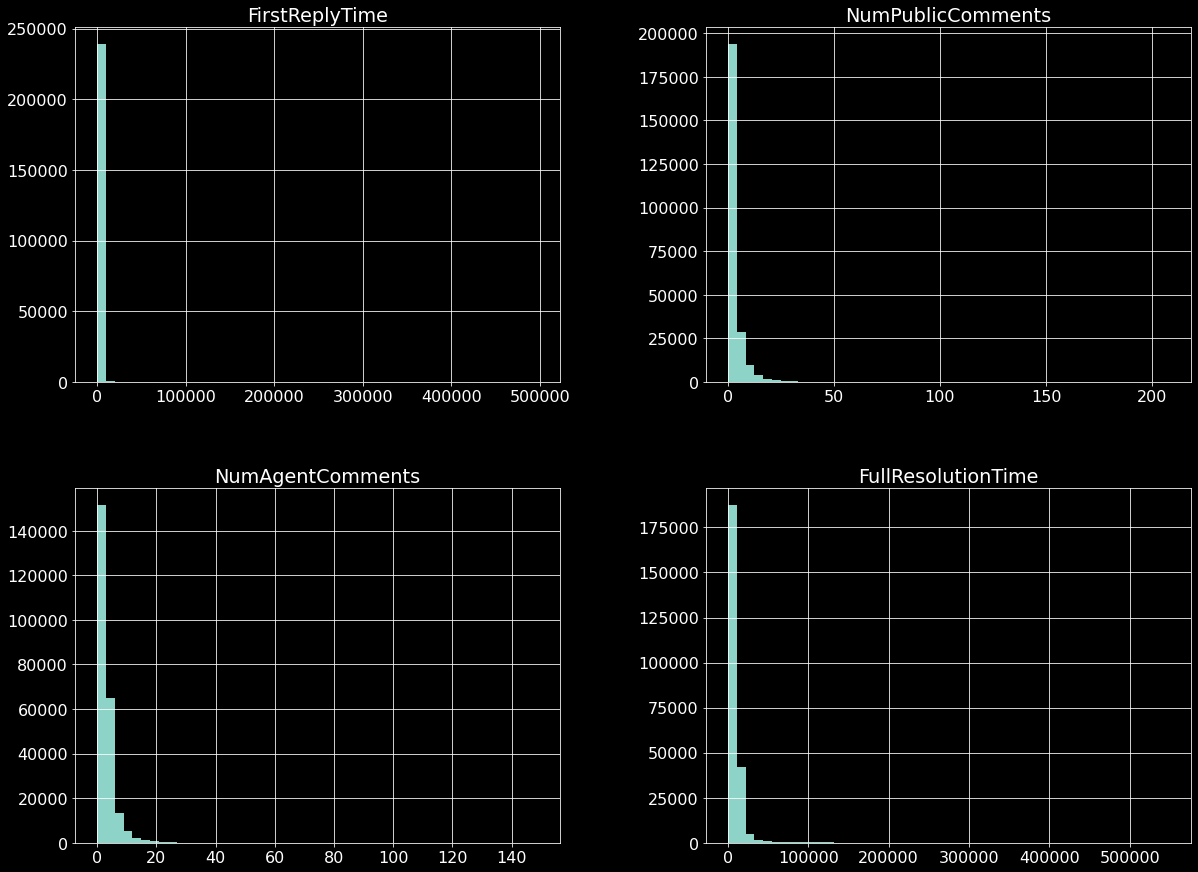

In [244]:
cols = ['FirstReplyTime', 'NumPublicComments', 'NumAgentComments', 'FullResolutionTime'] # one or more

df[cols].hist(bins=50, figsize=(20,15))
plt.show()

## EDA 


In [245]:
eda = df.copy()

Text(0.5, 1.0, 'ResolutionTime distribution')

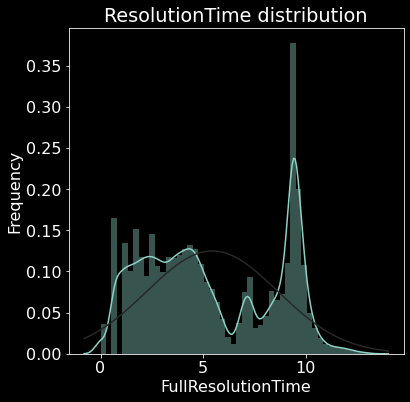

In [246]:
target = np.log1p(eda['FullResolutionTime']).dropna()

sns.distplot(target , fit=norm);

plt.ylabel('Frequency')
plt.title('ResolutionTime distribution')



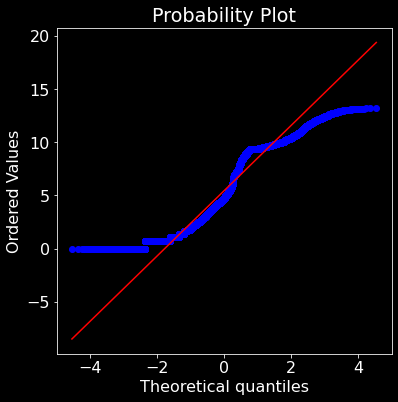

In [247]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target.astype(float), plot=plt)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x143479060>,
 'caps': [<matplotlib.lines.Line2D at 0x142b90430>,
 'boxes': [<matplotlib.lines.Line2D at 0x14347bd60>],
 'medians': [<matplotlib.lines.Line2D at 0x142b91870>],
 'fliers': [],
 'means': []}

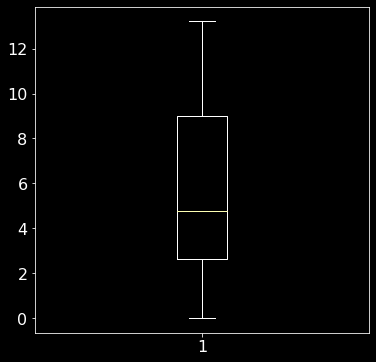

In [248]:
plt.boxplot(target, showfliers=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x1434c0820>,
 'caps': [<matplotlib.lines.Line2D at 0x1434c0dc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1434c0550>],
 'medians': [<matplotlib.lines.Line2D at 0x1434c1360>],
 'fliers': [],
 'means': []}

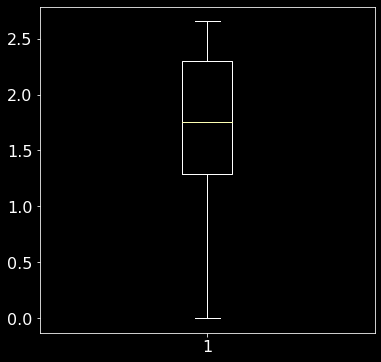

In [249]:
plt.boxplot(np.log1p(target), showfliers=False)

array([[<AxesSubplot:xlabel='FirstReplyTime', ylabel='FirstReplyTime'>,
        <AxesSubplot:xlabel='NumPublicComments', ylabel='FirstReplyTime'>,
        <AxesSubplot:xlabel='NumAgentComments', ylabel='FirstReplyTime'>,
        <AxesSubplot:xlabel='FullResolutionTime', ylabel='FirstReplyTime'>],
       [<AxesSubplot:xlabel='FirstReplyTime', ylabel='NumPublicComments'>,
        <AxesSubplot:xlabel='NumPublicComments', ylabel='NumPublicComments'>,
        <AxesSubplot:xlabel='NumAgentComments', ylabel='NumPublicComments'>,
        <AxesSubplot:xlabel='FullResolutionTime', ylabel='NumPublicComments'>],
       [<AxesSubplot:xlabel='FirstReplyTime', ylabel='NumAgentComments'>,
        <AxesSubplot:xlabel='NumPublicComments', ylabel='NumAgentComments'>,
        <AxesSubplot:xlabel='NumAgentComments', ylabel='NumAgentComments'>,
        <AxesSubplot:xlabel='FullResolutionTime', ylabel='NumAgentComments'>],
       [<AxesSubplot:xlabel='FirstReplyTime', ylabel='FullResolutionTime'>,
        <A

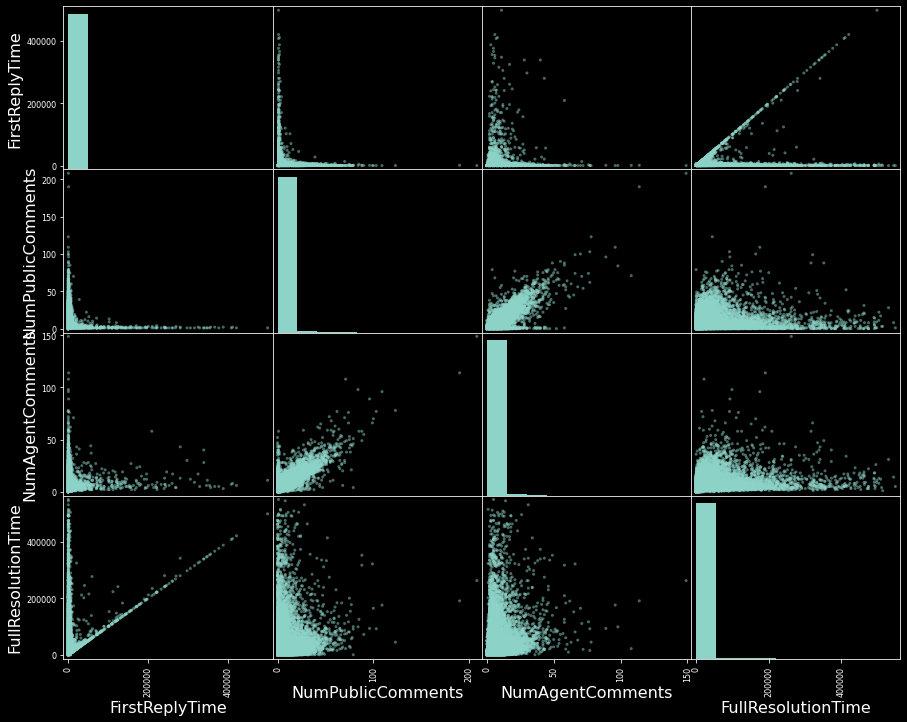

In [250]:
from pandas.plotting import scatter_matrix
scatter_matrix(eda[cols],figsize=(15,12))

In [259]:
eda['TicketCreatedDate'] = pd.to_datetime(eda['TicketCreatedDate'])
eda['TicketCreatedYear'] = eda['TicketCreatedDate'].dt.isocalendar().year
eda['TicketCreatedWeekNr'] = eda['TicketCreatedDate'].dt.isocalendar().week
eda['TicketClosedDate'] = pd.to_datetime((eda['TicketCreatedDate'] + pd.to_timedelta(eda['FullResolutionTime'], unit='min')).dt.date)
eda['SolvedSameDay'] = eda['TicketCreatedDate'] == eda['TicketClosedDate']

<AxesSubplot:xlabel='TicketCreatedYear,TicketCreatedWeekNr'>

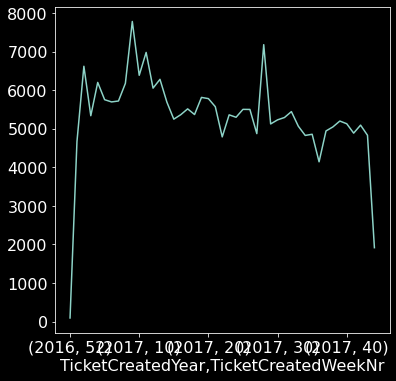

In [260]:
# Volume of tickets Overtime
eda.groupby(['TicketCreatedYear','TicketCreatedWeekNr'])['TicketID'].count().plot.line()

<AxesSubplot:xlabel='TicketCreatedYear,TicketCreatedWeekNr'>

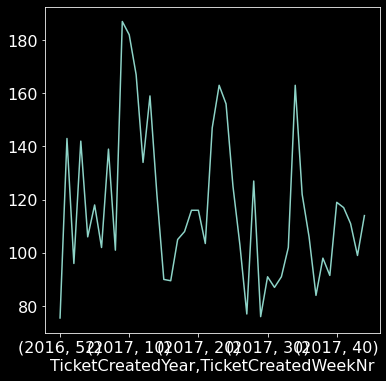

In [261]:
# time to solve tickets

eda.groupby(['TicketCreatedYear','TicketCreatedWeekNr'])['FullResolutionTime'].median().plot.line()

<AxesSubplot:>

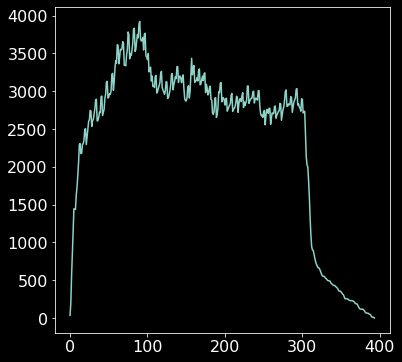

In [262]:
# daily ticket queue

def queue_size(date): 
    mask = (date >= eda['TicketCreatedDate']) & (date < eda['TicketClosedDate'])
    return eda.loc[mask]['TicketID'].count()

ts=pd.Series(pd.date_range(start=eda['TicketCreatedDate'].min(), end=eda['TicketClosedDate'].max()))
ts.apply (lambda row: queue_size(row)).plot.line()


In [267]:
def f(x):
    d = {}
    d['volume'] = x['TicketID'].count()
    d['response_rate'] = round(100*x[x['CustomerSatisfaction'] != 0]['TicketID'].count() / x['TicketID'].count(), 2)
    d['csat_score'] = round(100*x['CustomerSatisfaction'].sum()/x[x['CustomerSatisfaction'] != 0]['TicketID'].count() , 2)
    return pd.Series(d, index=['volume', 'response_rate', 'csat_score'])

eda.groupby('ZendeskPlan').apply(f).sort_values( by='volume', ascending=False)

,volume,response_rate,csat_score
ZendeskPlan,,,
None,62776.0,14.16,78.08
Enterprise Legacy,44452.0,22.78,92.22
Trial,33322.0,21.70,90.57
Professional,22866.0,22.37,89.52
Plus,18383.0,24.13,90.44
Non-Customer,12839.0,1.85,59.49
Team,11734.0,20.58,88.49
Expired,11210.0,21.09,89.26
Enterprise,7052.0,24.73,91.74


In [268]:
def f(x):
    d = {}
    d['volume'] = x['TicketID'].count()
    d['response_rate'] = round(100*x[x['CustomerSatisfaction'] != 0]['TicketID'].count() / x['TicketID'].count(), 2)
    d['csat_score'] = round(100*x['CustomerSatisfaction'].sum()/x[x['CustomerSatisfaction'] != 0]['TicketID'].count() , 2)
    return pd.Series(d, index=['volume', 'response_rate', 'csat_score'])

eda.groupby('TicketChannel').apply(f).sort_values( by='volume', ascending=False)

,volume,response_rate,csat_score
TicketChannel,,,
chat,87874.0,22.56,87.26
web,66105.0,21.80,88.52
email,44627.0,17.63,87.39
voice,32886.0,8.85,91.61
api,4752.0,10.73,82.75
twitter,2039.0,0.00,NaN
facebook,819.0,0.00,NaN
help_center,630.0,4.29,77.78
mobile,9.0,11.11,-100.00


<AxesSubplot:>

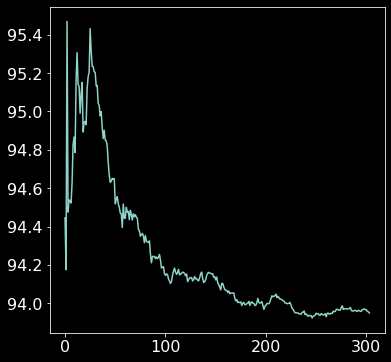

In [272]:
# CSAT Over time 
def csat(date): 
    mask = (date >= eda['TicketCreatedDate']) 
    return 100*eda.loc[(mask)  & (eda['CustomerSatisfaction'] == 1)]['CustomerSatisfaction'].count()/eda.loc[(mask) & (eda['CustomerSatisfaction'] != 0)]['TicketID'].count()

ts=pd.Series(pd.date_range(start=eda['TicketCreatedDate'].min(), end=eda['TicketCreatedDate'].max()))
ts.apply (lambda row: csat(row)).plot.line()

<AxesSubplot:xlabel='TicketCreatedYear,TicketCreatedWeekNr'>

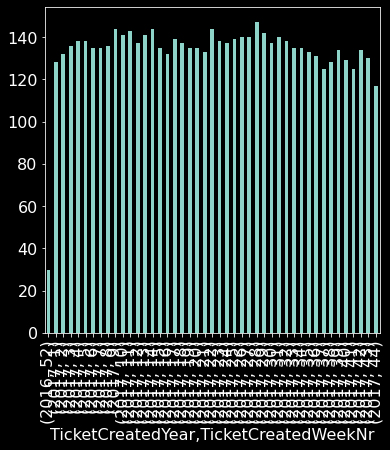

In [273]:
# Weekly Active Employees 
eda.groupby(['TicketCreatedYear','TicketCreatedWeekNr'])['EmployeeID'].nunique().plot.bar()

In [275]:
# average tickets solved per day per employee

eda.groupby(['EmployeeID']).agg({'TicketID':['count'], 
                         'FullResolutionTime':['count','median', 'mean'],
                         'FirstReplyTime': ['count', 'median'],
                         'NumAgentComments': 'median',
                         'NumPublicComments': 'median',
                         'TicketEscalated': 'sum'
                         }).sort_values(by=('TicketID','count'), ascending=False)


TicketID FullResolutionTime                        FirstReplyTime  \
              count              count    median         mean          count   
EmployeeID                                                                     
2081          14040              14040       5.0   166.566453          14040   
2050           7828               7828       9.0    322.87187           7828   
1463           7676               7676       6.0   250.369724           7676   
2149           4675               4675      60.0  4807.848342           4675   
2265           4549               4549      34.0   1202.26951           4549   
...             ...                ...       ...          ...            ...   
553               1                  1      78.0         78.0              1   
185               1                  1  172445.0     172445.0              1   
1498              1                  1    7411.0       7411.0              1   
2419              1                  1    4200.0       4200.0              1   
3411              1                  1   74973.0      74973.0              1   

                    NumAgentComments NumPublicComments TicketEscalated  
             median           median            median             sum  
EmployeeID                                                              
2081            0.0              0.0               0.0             254  
2050            0.0              0.0               0.0             140  
1463            0.0              0.0               0.0             100  
2149           16.0              2.0               2.0              74  
2265            2.0              1.0               2.0              94  
...             ...              ...               ...             ...  
553            78.0              3.0               2.0               0  
185           115.0              4.0               4.0               0  
1498          145.0              6.0               4.0               0  
2419         3128.0              8.0               3.0               1  
3411        70536.0             13.0              14.0               0  

[193 rows x 9 columns]

In [276]:
corr_matrix = eda.corr()
corr_matrix['FullResolutionTime'].sort_values(ascending=False)

FullResolutionTime      1.000000
NumAgentComments        0.392581
NumPublicComments       0.323451
FirstReplyTime          0.287875
TicketEscalated         0.224620
WorkerTenure            0.082985
TicketCreatedYear      -0.000196
TicketID               -0.028931
TicketCreatedWeekNr    -0.029429
CustomerSatisfaction   -0.037207
EmployeeID             -0.089498
SolvedSameDay          -0.414234
Name: FullResolutionTime, dtype: float64

## Preprocessing

In [281]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,-1,2014-06-01,Manila,Employee,962
925,1463,chat,Zopim T1,2132608,2017-01-06,None,Friday,None,0,4,0,0,0,0,2015-08-03,Manila,Employee,522
926,1463,chat,Zopim T1,2132014,2017-01-06,None,Friday,None,0,35,0,0,0,0,2015-08-03,Manila,Employee,522
927,1463,chat,Zopim T1,2878472,2017-08-18,None,Friday,None,0,0,0,0,0,0,2015-08-03,Manila,Employee,746
928,1463,chat,Zopim T1,2483674,2017-03-31,None,Friday,None,0,2,0,0,0,0,2015-08-03,Manila,Employee,606


In [282]:
df.set_index('TicketID')


di = {'None': 0, 'Triage': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 1': 3}
df.replace({"AssigneeTier": di}, inplace=True)

exclude = [
    'TicketID',
    'TicketCreatedDate',
    'WorkerDateHired'
]

df = df.drop(exclude, axis=1)

df.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure
924,688,chat,Zopim T1,None,Friday,0,0,13309,1,0,0,-1,Manila,Employee,962
925,1463,chat,Zopim T1,None,Friday,0,0,4,0,0,0,0,Manila,Employee,522
926,1463,chat,Zopim T1,None,Friday,0,0,35,0,0,0,0,Manila,Employee,522
927,1463,chat,Zopim T1,None,Friday,0,0,0,0,0,0,0,Manila,Employee,746
928,1463,chat,Zopim T1,None,Friday,0,0,2,0,0,0,0,Manila,Employee,606


In [283]:
from sklearn.preprocessing import LabelEncoder

df_cat = list(df.select_dtypes(include=object))

# process columns, apply LabelEncoder to categorical features
for c in df_cat:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))
    

df.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure
924,688,1,26,7,0,0,0,13309,1,0,0,-1,5,1,962
925,1463,1,26,7,0,0,0,4,0,0,0,0,5,1,522
926,1463,1,26,7,0,0,0,35,0,0,0,0,5,1,522
927,1463,1,26,7,0,0,0,0,0,0,0,0,5,1,746
928,1463,1,26,7,0,0,0,2,0,0,0,0,5,1,606


In [284]:
corr_matrix = df.corr()
corr_matrix['FullResolutionTime'].sort_values(ascending=False)

FullResolutionTime      1.000000
NumAgentComments        0.392581
NumPublicComments       0.323451
FirstReplyTime          0.287875
TicketEscalated         0.224620
TicketChannel           0.133242
WorkerTenure            0.082985
AssigneeTier            0.064433
WorkerLocation          0.048468
TicketGroup             0.021024
Worker_Type             0.003482
DayTicketSolved        -0.008824
CustomerSatisfaction   -0.037207
ZendeskPlan            -0.066580
EmployeeID             -0.089498
Name: FullResolutionTime, dtype: float64

## Regression 



In [309]:
from sklearn.metrics import mean_squared_error,roc_auc_score, auc, roc_curve, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
import optuna

cv = KFold(n_splits=4)

In [310]:
df_model = df.copy()

y = df_model.pop('FullResolutionTime')
X = df_model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Linear Regression

RMSE of linear regression on test set: 16502.91
R2 of linear regression on test set: 0.21


(array([2.0000e+00, 7.0000e+00, 4.6951e+04, 7.2600e+02, 1.4300e+02,
        6.4000e+01, 2.5000e+01, 2.2000e+01, 5.0000e+00, 4.0000e+00]),
 array([-195026.03156991376, -124485.9279008799, -53945.824231846054,
        16594.279437187797, 87134.38310622165, 157674.4867752555,
        228214.59044428935, 298754.69411332323, 369294.7977823571,
        439834.90145139094, 510375.0051204248], dtype=object),
 <BarContainer object of 10 artists>)

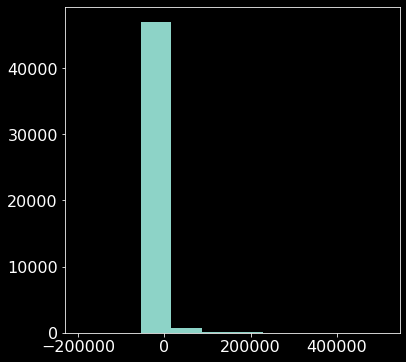

In [311]:
from sklearn.linear_model import LinearRegression, LassoCV

model = LinearRegression()
score = cross_val_score(
     model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('RMSE of linear regression on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R2 of linear regression on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred)

<AxesSubplot:xlabel='preds', ylabel='residuals'>

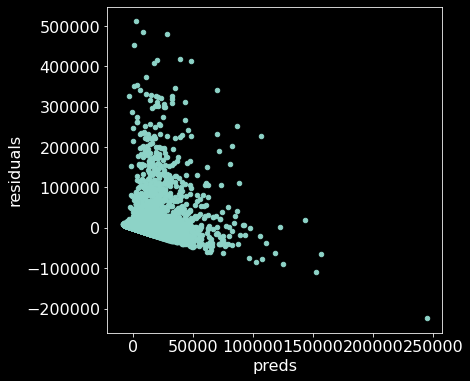

In [302]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": y_pred, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

-1.1788284851683806e+16
RMSE of linear regression on test set: 78952785975677.14
R2 of linear regression on test set: -18069666836973694976.00


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7948e+04]),
 array([-1.7286551551668702e+16, -1.5557896396450476e+16,
        -1.3829241241232252e+16, -1.2100586086014028e+16,
        -1.0371930930795802e+16, -8643275775577577.0, -6914620620359352.0,
        -5185965465141126.0, -3457310309922902.0, -1728655154704678.0,
        513547.14595843625], dtype=object),
 <BarContainer object of 10 artists>)

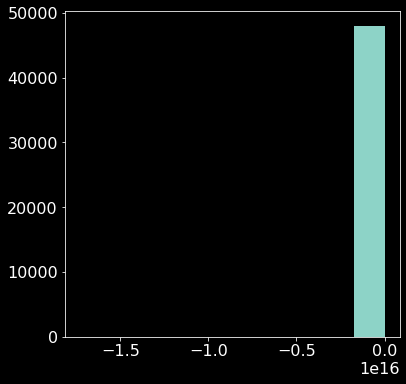

In [303]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay

model = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
)
score = cross_val_score(
     model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
print(score)

model.fit(X_train, y_train)

y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

print('RMSE of linear regression on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_ridge_with_trans_target))))
print('R2 of linear regression on test set: {:.2f}'.format(r2_score(y_test, y_pred_ridge_with_trans_target)))
plt.hist(y_test - y_pred_ridge_with_trans_target)

## Improvements

### Normalize Target Var

MSE of rf on test set: 2.10
R2 of rf on test set: 0.57


(array([1.0000e+00, 5.0000e+00, 5.0000e+00, 2.1000e+01, 1.1030e+03,
        2.1739e+04, 1.6900e+04, 7.3670e+03, 7.1400e+02, 9.4000e+01]),
 array([-16.065173239846956, -13.466520412244423, -10.867867584641889,
        -8.269214757039354, -5.67056192943682, -3.0719091018342866,
        -0.4732562742317512, 2.1253965533707806, 4.724049380973316,
        7.322702208575851, 9.921355036178385], dtype=object),
 <BarContainer object of 10 artists>)

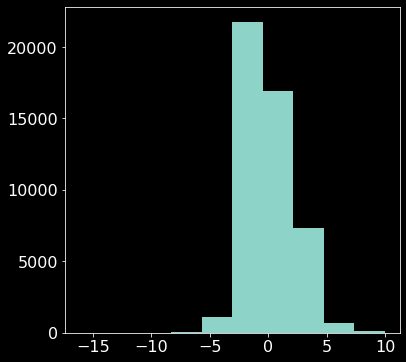

In [308]:
df_model = df.copy()

df_model['FullResolutionTime'] = np.log1p(df_model['FullResolutionTime'])
df_model['FirstReplyTime'] = np.log1p(df_model['FirstReplyTime'])

y = df_model.pop('FullResolutionTime')
X = df_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

score = cross_val_score(
     model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('MSE of rf on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred)


<AxesSubplot:xlabel='preds', ylabel='residuals'>

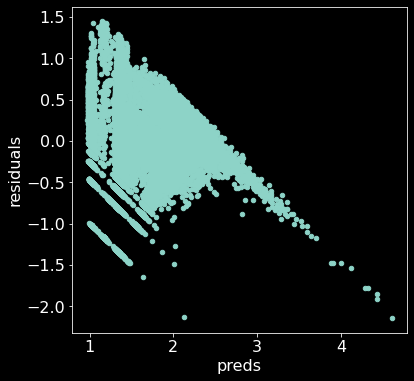

In [157]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": y_pred, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Random Forest Regression

In [215]:
rf_params = {
    'max_depth': 10, 
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': 27,
    "n_estimators": 122
}

RMSE of rf on test set: 15408.91
R2 of rf on test set: 0.31


(array([1.4000e+01, 1.4700e+02, 4.7238e+04, 3.3100e+02, 1.1600e+02,
        4.7000e+01, 2.9000e+01, 1.8000e+01, 5.0000e+00, 4.0000e+00]),
 array([-164725.56600950353, -100819.14825952897, -36912.73050955443,
        26993.687240420113, 90900.10499039467, 154806.52274036923,
        218712.94049034375, 282619.35824031837, 346525.7759902929,
        410432.1937402674, 474338.61149024195], dtype=object),
 <BarContainer object of 10 artists>)

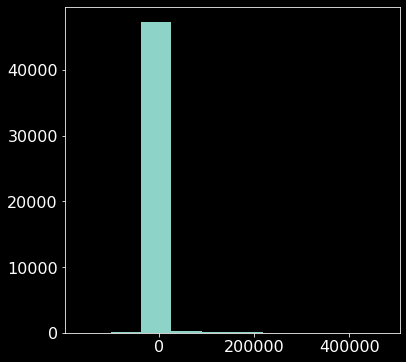

In [312]:
rf = RandomForestRegressor(**rf_params)

stack_scores = cross_val_score(
    rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)

rf.fit(X_train.values, y_train.values)
y_pred = rf.predict(X_test)

print('RMSE of rf on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred) 

<AxesSubplot:xlabel='preds', ylabel='residuals'>

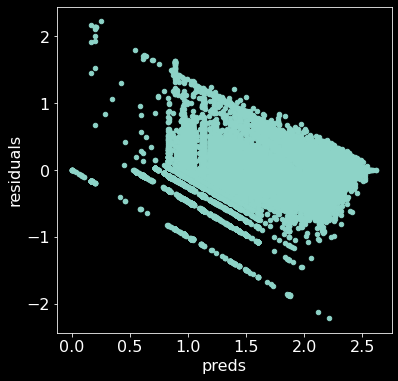

In [165]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": y_pred, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [180]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

permutation_importances(rf, X_train, y_train, r2)

,Importance
Feature,
FirstReplyTime,0.627184
NumPublicComments,0.321584
TicketGroup,0.195431
TicketChannel,0.168982
NumAgentComments,0.131505
WorkerLocation,0.034460
CustomerSatisfaction,0.016522
EmployeeID,0.015885
ZendeskPlan,0.013547


In [216]:
def objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 12)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 8)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 6)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestRegressor(
     max_depth=_max_depth,
     min_samples_split=_min_samp_split,
     min_samples_leaf=_min_samples_leaf,
     max_features=_max_features,
     n_estimators=_n_estimators,
     n_jobs=-1,
     random_state=42,
    )

    score = cross_val_score(
     rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

rf_params = study.best_params
rf_best_score = study.best_value
print(f"Best score:{rf_best_score} \nOptimized parameters: {rf_params}")

Best score:-0.2902123595801012 
Optimized parameters: {'n_estimators': 157, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 10}


RMSE of rf on test set: 0.29
R2 of rf on test set: 0.76


(array([1.3000e+01, 5.5000e+01, 2.8000e+02, 2.2990e+03, 2.1213e+04,
        2.0859e+04, 2.8790e+03, 3.1600e+02, 3.3000e+01, 2.0000e+00]),
 array([-2.172777311929447, -1.7404292967080526, -1.3080812814866578,
        -0.875733266265263, -0.4433852510438685, -0.011037235822473956,
        0.42131077939892103, 0.8536587946203156, 1.2860068098417101,
        1.7183548250631047, 2.1507028402844988], dtype=object),
 <BarContainer object of 10 artists>)

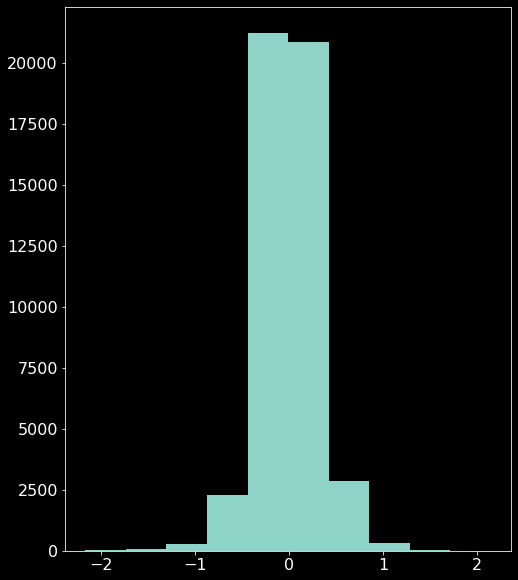

In [217]:
rf_params = {
    'max_depth': 12, 
    'min_samples_split': 4,
    'min_samples_leaf': 4,
    'max_features': 10,
    "n_estimators": 157
}

rf = RandomForestRegressor(**rf_params)

stack_scores = cross_val_score(
    rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)

rf.fit(X_train.values, y_train.values)
y_pred = rf.predict(X_test)

print('RMSE of rf on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred) 

<AxesSubplot:xlabel='preds', ylabel='residuals'>

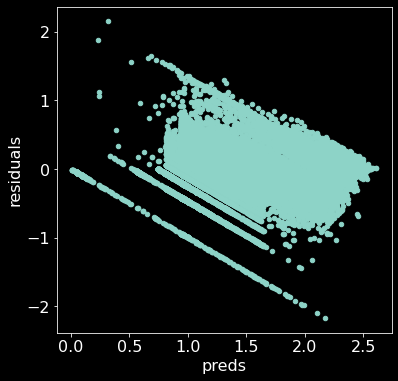

In [219]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": y_pred, "true": y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Feature Engineering

In [185]:
df_raw.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
0,938,chat,Support (T1),2536525,2017-04-20,Enterprise Legacy,None,Tier 1,317,<NA>,11,15,0,<NA>,2014-11-10,Dublin,Employee,892
1,938,chat,Support (T1),2522091,2017-04-14,Enterprise Legacy,None,Tier 1,10260,<NA>,14,22,0,<NA>,2014-11-10,Dublin,Employee,886
2,1247,web,Support (T1),2836287,2017-08-03,Enterprise Legacy,None,Tier 1,<NA>,<NA>,4,<NA>,0,<NA>,2015-04-20,Dublin,Employee,836
3,919,help_center,Support (T1),3003180,2017-10-02,Enterprise Legacy,None,Tier 1,<NA>,<NA>,3,1,0,<NA>,2014-10-27,Madison,Employee,1071
4,919,help_center,Support (T1),3003011,2017-10-02,Enterprise Legacy,None,Tier 1,<NA>,<NA>,3,1,0,<NA>,2014-10-27,Madison,Employee,1071


In [186]:
for col in ('AssigneeTier', 'ZendeskPlan'):
    df_raw[col] = df_raw[col].fillna('None')

for col in ('NumPublicComments', 'NumAgentComments'):
    df_raw[col] = df_raw[col].fillna(0)

df_raw['FirstReplyTime'] = df_raw['FirstReplyTime'].fillna(0)

# Drop open tickets
df_raw = df_raw.dropna(subset=['FullResolutionTime', 'DayTicketSolved'])

df_raw["CustomerSatisfaction"] = df_raw["CustomerSatisfaction"].replace({0: -1}).fillna(0)

In [187]:
df_raw['TicketClosedDate'] = pd.to_datetime((pd.to_datetime(df_raw['TicketCreatedDate']) + pd.to_timedelta(df_raw['FullResolutionTime'], unit='m')).dt.date)
df_raw['TicketCreatedDate'] = pd.to_datetime(df_raw['TicketCreatedDate'])

def queue_size(eID, date): 
    mask = (date >= df_raw['TicketCreatedDate']) & (date < df_raw['TicketClosedDate'])
    return df_raw[df_raw['EmployeeID'] == eID].loc[mask]['TicketID'].count()

ts = pd.date_range(start=df_raw['TicketCreatedDate'].min(), end=df_raw['TicketClosedDate'].max())
eID = (list(df_raw['EmployeeID'].unique()))

In [188]:
multi_index = pd.MultiIndex.from_product([eID,ts], names=["EmployeeID", "Date"]).to_frame()
multi_index.reset_index(drop=True, inplace=True)

# iterate through employees
multi_index['QueueSize'] = multi_index.apply(lambda x: queue_size(x['EmployeeID'], x['Date']), axis=1)
multi_index.set_index(['EmployeeID','Date'], inplace=True)

df_raw['NrOpenTickets'] = df_raw.apply(lambda x: multi_index.loc[x['EmployeeID'], x['TicketCreatedDate']], axis=1)
df_raw.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure,TicketClosedDate,NrOpenTickets
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,-1,2014-06-01,Manila,Employee,962,2017-01-27,4
925,1463,chat,Zopim T1,2132608,2017-01-06,None,Friday,None,0,4,0,0,0,0,2015-08-03,Manila,Employee,522,2017-01-06,2
926,1463,chat,Zopim T1,2132014,2017-01-06,None,Friday,None,0,35,0,0,0,0,2015-08-03,Manila,Employee,522,2017-01-06,2
927,1463,chat,Zopim T1,2878472,2017-08-18,None,Friday,None,0,0,0,0,0,0,2015-08-03,Manila,Employee,746,2017-08-18,3
928,1463,chat,Zopim T1,2483674,2017-03-31,None,Friday,None,0,2,0,0,0,0,2015-08-03,Manila,Employee,606,2017-03-31,0


In [189]:
df_model = df_raw.copy()

df_model['FullResolutionTime'] = np.log1p(df_model['FullResolutionTime'])
df_model['FirstReplyTime'] = np.log1p(df_model['FirstReplyTime'])

df_model.set_index('TicketID')


di = {'None': 0, 'Triage': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 1': 3}
df.replace({"AssigneeTier": di}, inplace=True)

exclude = [
    'TicketID',
    'TicketCreatedDate',
    'WorkerDateHired',
    'TicketClosedDate'
]

df_model = df_model.drop(exclude, axis=1)

df_model.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure,TicketClosedDate,NrOpenTickets
924,688,chat,Zopim T1,None,Friday,None,0.0,9.496271,1,0,0,-1,Manila,Employee,962,2017-01-27,4
925,1463,chat,Zopim T1,None,Friday,None,0.0,1.609438,0,0,0,0,Manila,Employee,522,2017-01-06,2
926,1463,chat,Zopim T1,None,Friday,None,0.0,3.583519,0,0,0,0,Manila,Employee,522,2017-01-06,2
927,1463,chat,Zopim T1,None,Friday,None,0.0,0.0,0,0,0,0,Manila,Employee,746,2017-08-18,3
928,1463,chat,Zopim T1,None,Friday,None,0.0,1.098612,0,0,0,0,Manila,Employee,606,2017-03-31,0


In [196]:
# process columns, apply LabelEncoder to categorical features
for c in df_cat:
    lbl = LabelEncoder() 
    lbl.fit(list(df_model[c].values)) 
    df_model[c] = lbl.transform(list(df_model[c].values))
    

df_model.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure,NrOpenTickets
924,688,1,26,7,0,0,0.0,9.496271,1,0,0,-1,5,1,962,4
925,1463,1,26,7,0,0,0.0,1.609438,0,0,0,0,5,1,522,2
926,1463,1,26,7,0,0,0.0,3.583519,0,0,0,0,5,1,522,2
927,1463,1,26,7,0,0,0.0,0.0,0,0,0,0,5,1,746,3
928,1463,1,26,7,0,0,0.0,1.098612,0,0,0,0,5,1,606,0


In [207]:
df_model['Workload'] = df_model['NrOpenTickets']/df_model['WorkerTenure']

In [208]:
corr_matrix = df_model.corr()
corr_matrix['FullResolutionTime'].sort_values(ascending=False)

FullResolutionTime      1.000000
FirstReplyTime          0.670031
NumPublicComments       0.506921
NumAgentComments        0.459622
TicketEscalated         0.373763
NrOpenTickets           0.339590
TicketChannel           0.260109
Workload                0.212150
AssigneeTier            0.113699
WorkerLocation          0.053964
WorkerTenure            0.051527
CustomerSatisfaction    0.039248
DayTicketSolved        -0.010984
Worker_Type            -0.014857
ZendeskPlan            -0.037085
EmployeeID             -0.049360
TicketGroup            -0.188790
Name: FullResolutionTime, dtype: float64

In [ ]:
y = df_model.pop('FullResolutionTime')
X = df_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

MSE of rf on test set: 2.09
R2 of rf on test set: 0.57


(array([1.0000e+00, 4.0000e+00, 5.0000e+00, 8.0000e+00, 2.1100e+02,
        1.9113e+04, 1.9114e+04, 8.6170e+03, 7.9500e+02, 8.1000e+01]),
 array([-17.716804831249895, -14.92052260670497, -12.124240382160044,
        -9.327958157615118, -6.5316759330701935, -3.735393708525269,
        -0.9391114839803407, 1.8571707405645839, 4.6534529651095085,
        7.449735189654433, 10.246017414199361], dtype=object),
 <BarContainer object of 10 artists>)

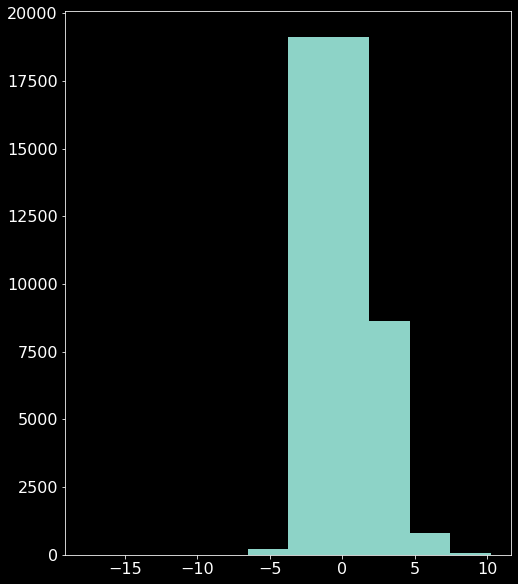

In [212]:
score = cross_val_score(
     rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()

rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE of rf on test set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('R2 of rf on test set: {:.2f}'.format(r2_score(y_test, y_pred)))
plt.hist(y_test - y_pred)


In [213]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

permutation_importances(rf, X_train, y_train, r2)

,Importance
Feature,
FirstReplyTime,0.641332
NumPublicComments,0.343939
TicketChannel,0.153429
NumAgentComments,0.132576
TicketGroup,0.116610
WorkerLocation,0.035379
AssigneeTier,0.021096
NrOpenTickets,0.016805
CustomerSatisfaction,0.009741


## Fine-Tuning

## Classification

In [49]:
df.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,WorkerLocation,Worker_Type,WorkerTenure,NrOpenTickets,TicketCreatedMonth,HasResponded,Workload
924,688,1,26,7,0,0,0.0,9.496271,1,0,0,5,1,962,4,1,1,0
925,1463,1,26,7,0,0,0.0,1.609438,0,0,0,5,1,522,2,1,0,0
926,1463,1,26,7,0,0,0.0,3.583519,0,0,0,5,1,522,2,1,0,0
927,1463,1,26,7,0,0,0.0,0.0,0,0,0,5,1,746,3,8,0,0
928,1463,1,26,7,0,0,0.0,1.098612,0,0,0,5,1,606,0,3,0,0


In [68]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import optuna

cv = KFold(n_splits=4)

In [65]:
df_model = df.copy()

y = df_model.pop('HasResponded')
X = df_model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Random under-sampling:
0    155283
1     36509
Name: HasResponded, dtype: int64


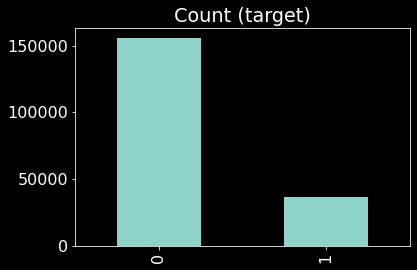

In [59]:
print('Random under-sampling:')
print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Count (target)');

Random under-sampling:
0    36509
1    36509
Name: HasResponded, dtype: int64


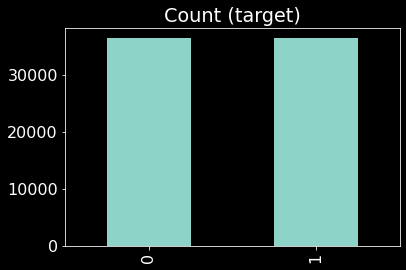

In [62]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_train, y_train  = rus.fit_resample(X_train, y_train)

print('Random under-sampling:')
print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Count (target)');

In [63]:
def baseline(train, test, target, model): 
    cv = KFold(n_splits=5)
    
    # Data Normalization
    sc = StandardScaler()
    train = sc.fit_transform(train)
    test = sc.transform(test)

    score = cross_val_score(model, train, target, cv=cv, scoring="roc_auc")
    print('%.3f' % score.mean())

    model.fit(train, target)
    predictions = model.predict(test)

    return predictions

#### Dummy Classifier

In [75]:
dummy_clf = DummyClassifier(strategy="stratified")
y_pred = baseline(X_train, X_test, y_train, dummy_clf)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

0.501
[[31549  7355]
 [ 7258  1787]]
Precision: 0.195
Recall: 0.198
F1: 0.197
Accuracy: 0.695


In [71]:
lr = LogisticRegression(penalty='l2', class_weight='balanced')
y_pred = baseline(X_train, X_test, y_train, lr)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

0.630
[[23265 15639]
 [ 3643  5402]]
Precision: 0.257
Recall: 0.597
F1: 0.359
Accuracy: 0.598


In [55]:
rf = RandomForestClassifier()
y_pred = baseline(X_train, X_test, y_train, rf)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

0.688
[[37411  1493]
 [ 8175   870]]
Precision: 0.368
Recall: 0.096
F1: 0.153
Accuracy: 0.798


In [57]:
rf.feature_importances_

array([0.06870891, 0.02503742, 0.01992301, 0.05704075, 0.04992943,
       0.00593143, 0.10825788, 0.19826642, 0.03941673, 0.04626658,
       0.00506565, 0.02448688, 0.00025577, 0.12945473, 0.08457512,
       0.05985479, 0.07752849])

## Improvements

In [76]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [77]:
kmeans.fit(df)


KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [79]:
# The lowest SSE value
print(kmeans.inertia_)


# Final locations of the centroid
print(kmeans.cluster_centers_)


# The number of iterations required to converge
print(kmeans.n_iter_)

25798448040.741917
[[2.52789569e+03 4.32285270e+00 1.48339077e+01 7.24164503e+00
  3.28024658e+00 1.88557872e+00 3.14728869e+00 5.81706342e+00
  2.44919059e+00 2.99889571e+00 7.74215470e-02 4.05158605e+00
  1.00000000e+00 1.97226343e+02 2.76469068e+01 5.92516322e+00
  2.02339635e-01 5.20342087e+01]
 [8.57335880e+02 4.58798283e+00 1.79260730e+01 6.79783262e+00
  3.34221030e+00 1.43693133e+00 3.28831887e+00 6.32786035e+00
  3.48594421e+00 4.22929185e+00 3.22317597e-01 4.17437768e+00
  9.94141631e-01 1.04593464e+03 2.75736910e+01 5.13364807e+00
  1.86995708e-01 3.93903219e+01]
 [1.77542974e+03 3.46229286e+00 1.92264054e+01 7.05347903e+00
  3.29419786e+00 1.20087597e+00 2.30779210e+00 4.79374111e+00
  2.10095272e+00 2.57772159e+00 1.47442091e-01 4.06661850e+00
  9.97001851e-01 5.24487606e+02 1.94312006e+01 4.94204181e+00
  1.82110444e-01 2.96728857e+01]]
6


In [80]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

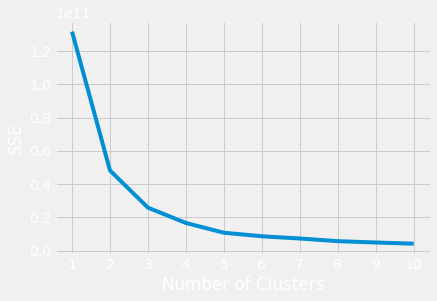

In [81]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [82]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [84]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

KeyboardInterrupt: 

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

features, true_labels = X_test, y_test

# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(features)
dbscan.fit(features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    features, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
   features, dbscan.labels_
).round (2)